In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display
import ipywidgets
import numpy
import pandas
import pathlib
import arviz
import pymc3
import aesara.tensor as at
from matplotlib import cm, pyplot
from robotools.transform import make_well_array

import calibr8
import models
import plotting

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [3]:
DP_DATA = pathlib.Path("..") / "data"

### The Plate Layout

In [4]:
wells_96 = make_well_array(R=8, C=12)

In [5]:
df_layout = pandas.read_excel(DP_DATA / "WellDescription.xlsx").rename(columns={
    "Well": "well",
    "Content": "content",
    "Product, mM": "product",
})
df_layout["well"] = wells_96.flatten("C")
df_layout = df_layout.set_index("well")
df_layout

,content,product
well,,
A01,Reactor,NaN
A02,Reactor,NaN
A03,NaN,NaN
A04,NaN,NaN
A05,NaN,NaN
...,...,...
H08,NaN,NaN
H09,NaN,NaN
H10,NaN,NaN


### Absorbances

In [6]:
def read_absorbances(fp) -> pandas.DataFrame:
    df = pandas.read_csv(fp, sep=";", index_col=0)
    df.rename(inplace=True, columns={
        c : f"{c[0]}{int(c[1:]):02d}"
        for c in df.columns
    })
    df["time_hours"] = (df.index - df.index[0]) / 3600
    return df.set_index("time_hours")
df_A360 = read_absorbances(DP_DATA / "Placeholder_Absorbance_360nm.csv")
df_A600 = read_absorbances(DP_DATA / "Placeholder_Absorbance_600nm.csv")

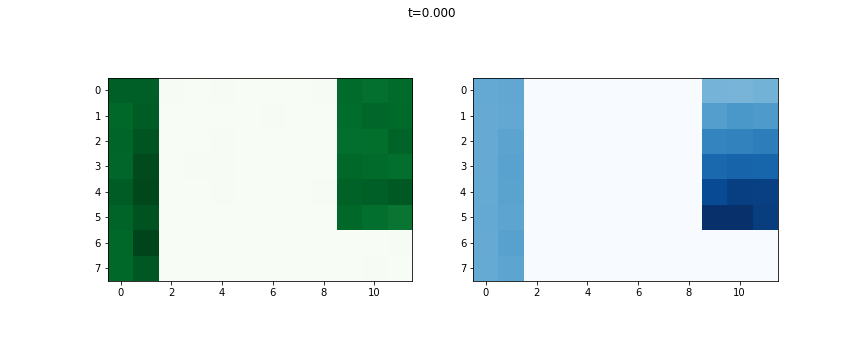

In [7]:
def plot_timepoint(t):
    fig, axs = pyplot.subplots(ncols=2, figsize=(12, 5))

    axs[0].imshow(
        df_A600.loc[t].to_numpy().reshape(8, 12, order="C"),
        cmap=cm.Greens
    )
    axs[1].imshow(
        df_A360.loc[t].to_numpy().reshape(8, 12, order="C"),
        cmap=cm.Blues
    )
    fig.suptitle(f"t={t:.3f}")

fp_out = plotting.plot_gif(
    fn_plot=plot_timepoint,
    fp_out="absorbance_2d.gif",
    data=df_A600.index,
    fps=1
)
IPython.display.Image(fp_out)

In [8]:
def plot_content(content: str):
    fig, axs = pyplot.subplots(ncols=2, figsize=(12, 4), dpi=140, sharex=True)

    wells = df_layout[df_layout.content == content].index
    ax = axs[0]
    ax.plot(df_A360.index, df_A360[wells], label="360 nm")
    ax.set(
        ylabel="absorbance at 360 mm",
        xlabel="time   [h]",
        ylim=(0, 2.5),
    )

    ax = axs[1]
    ax.plot(df_A360.index, df_A600[wells], label="600 nm")
    ax.set(
        ylabel="absorbance at 600 mm",
        xlabel="time   [h]",
        ylim=(0, 1),
        xlim=(0, None),
    )
    fig.tight_layout()
    pyplot.show()
    
ipywidgets.interact(
    plot_content,
    content=numpy.unique(df_layout.content.dropna())
);

interactive(children=(Dropdown(description='content', options=('Reactor', 'cal_0', 'cal_1', 'cal_2', 'cal_3', …

### Empirical observations to motivate further analyses

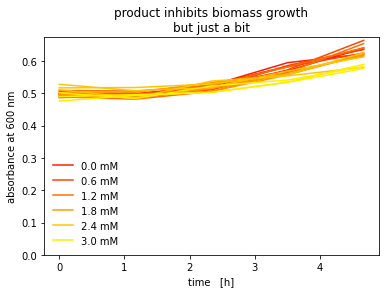

In [9]:
plotting.plot_calibration_biomass_observations(df_layout, df_A600)

### Select data for correlations

In [10]:
reaction_wells = df_layout.loc[df_layout.content.str.contains("cal_") == False].index
calibration_wells = df_layout.loc[df_layout.content.str.contains("cal_") == True].index
IPython.display.display(df_layout.loc[calibration_wells].T)
IPython.display.display(df_A600[calibration_wells])

well,A10,A11,A12,B10,B11,B12,C10,C11,C12,D10,D11,D12,E10,E11,E12,F10,F11,F12
content,cal_0,cal_0,cal_0,cal_1,cal_1,cal_1,cal_2,cal_2,cal_2,cal_3,cal_3,cal_3,cal_4,cal_4,cal_4,cal_5,cal_5,cal_5
product,0.0,0.0,0.0,0.6,0.6,0.6,1.2,1.2,1.2,1.8,1.8,1.8,2.4,2.4,2.4,3.0,3.0,3.0


,A10,A11,A12,B10,B11,B12,C10,C11,C12,D10,D11,D12,E10,E11,E12,F10,F11,F12
time_hours,,,,,,,,,,,,,,,,,,
0.000000,0.498,0.487,0.498,0.496,0.506,0.500,0.489,0.492,0.509,0.502,0.497,0.490,0.511,0.517,0.528,0.502,0.490,0.476
1.168889,0.495,0.492,0.499,0.499,0.495,0.486,0.482,0.495,0.507,0.503,0.492,0.488,0.486,0.518,0.508,0.484,0.496,0.494
2.335833,0.526,0.525,0.523,0.511,0.526,0.513,0.506,0.518,0.525,0.533,0.506,0.515,0.538,0.529,0.518,0.523,0.503,0.503
3.502778,0.584,0.595,0.570,0.573,0.582,0.586,0.566,0.565,0.582,0.560,0.557,0.559,0.554,0.558,0.569,0.541,0.534,0.535
4.669444,0.636,0.622,0.641,0.664,0.625,0.637,0.616,0.654,0.641,0.621,0.623,0.619,0.581,0.626,0.613,0.583,0.577,0.590


Because we don't have a proper biomass calibration, well assume some proportionalities:

$$A_{600} \propto X$$
$$A_{360} \propto X$$

In [11]:
df_rel_biomass = df_A600[calibration_wells] / df_A600[calibration_wells].loc[0]
df_rel_biomass

,A10,A11,A12,B10,B11,B12,C10,C11,C12,D10,D11,D12,E10,E11,E12,F10,F11,F12
time_hours,,,,,,,,,,,,,,,,,,
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.168889,0.993976,1.010267,1.002008,1.006048,0.978261,0.972,0.985685,1.006098,0.996071,1.001992,0.989940,0.995918,0.951076,1.001934,0.962121,0.964143,1.012245,1.037815
2.335833,1.056225,1.078029,1.050201,1.030242,1.039526,1.026,1.034765,1.052846,1.031434,1.061753,1.018109,1.051020,1.052838,1.023211,0.981061,1.041833,1.026531,1.056723
3.502778,1.172691,1.221766,1.144578,1.155242,1.150198,1.172,1.157464,1.148374,1.143418,1.115538,1.120724,1.140816,1.084149,1.079304,1.077652,1.077689,1.089796,1.123950
4.669444,1.277108,1.277207,1.287149,1.338710,1.235178,1.274,1.259714,1.329268,1.259332,1.237052,1.253521,1.263265,1.136986,1.210832,1.160985,1.161355,1.177551,1.239496


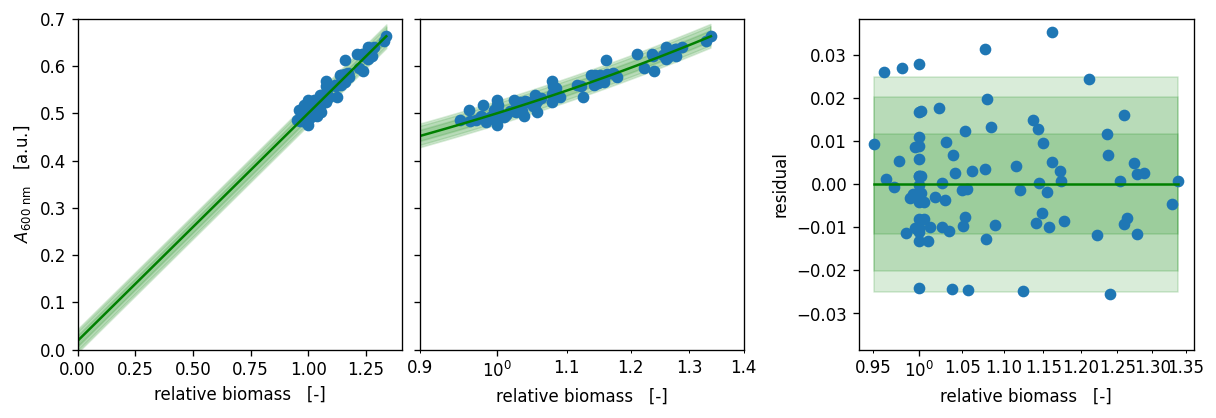

In [12]:
cm_600 = models.LinearBiomassAbsorbanceModel(independent_key="X", dependent_key="A600")
calibr8.fit_scipy(
    cm_600,
    independent=df_rel_biomass.to_numpy().flatten(),
    dependent=df_A600[calibration_wells].to_numpy().flatten(),
    theta_guess=[0.5, 0, 0.2, 3],
    theta_bounds=[
        (0, 2),
        (-0.5, 0.5),
        (0.01, 1),
        (1, 30),
    ]
)

plotting.plot_cmodel(cm_600)

### Plots to make informed guesses about A360/X and A360/P relationships

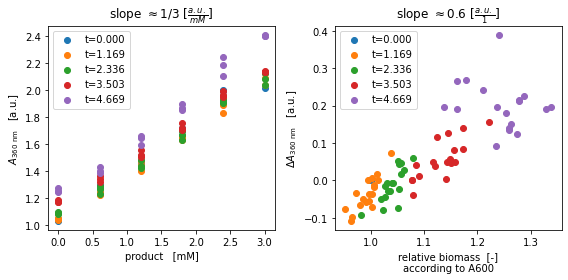

In [13]:
plotting.plot_A360_relationships(df_layout, df_A360, df_rel_biomass, calibration_wells)

### Build a model to describe the biomass contribution to $A_{360}$

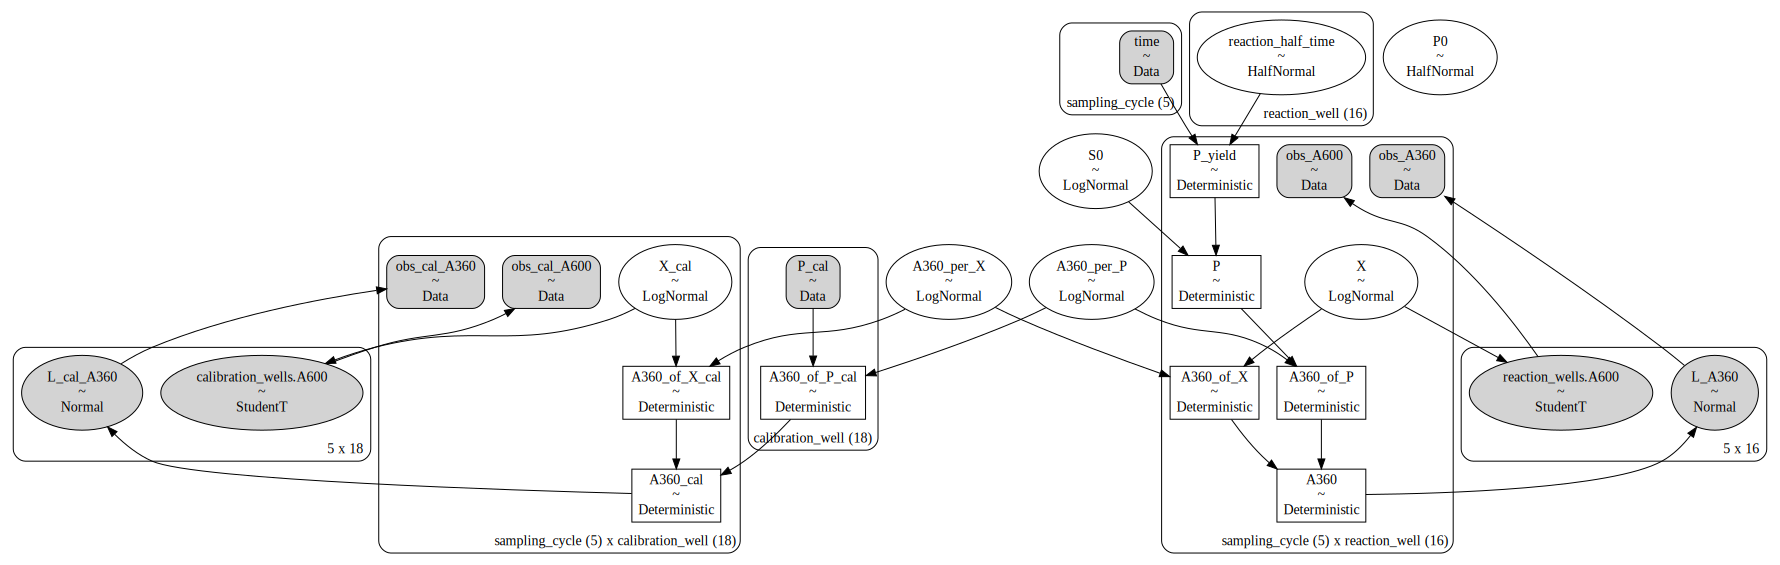

In [14]:
pmodel = models.build_model(
    df_layout, df_A360, df_A600,
    cm_600,
    calibration_wells, reaction_wells
)
pymc3.model_to_graphviz(pmodel)

In [15]:
with pmodel:
    idata = pymc3.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X_cal, A360_per_X, A360_per_P, X, S0, P0, reaction_half_time]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 36 seconds.


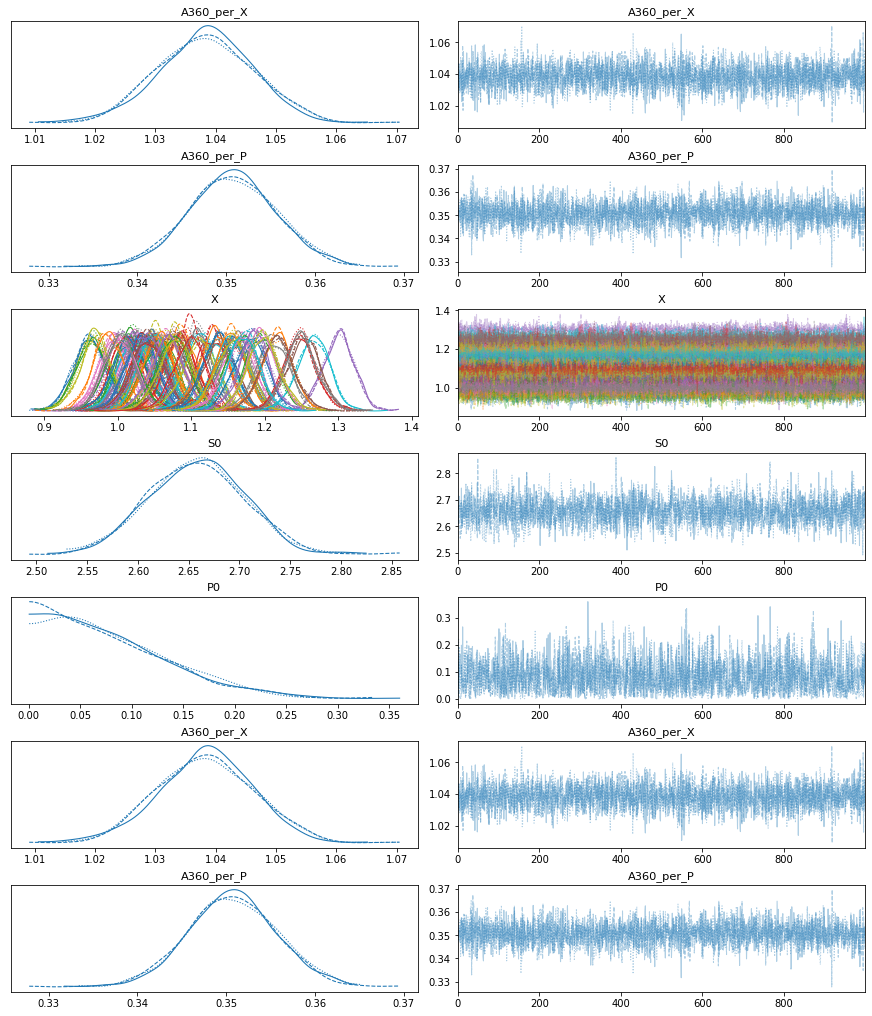

In [16]:
arviz.plot_trace(idata, var_names=[
    "A360_per_X", "A360_per_P",
    "X", "S0", "P0", "A360_per_X", "A360_per_P",
]);

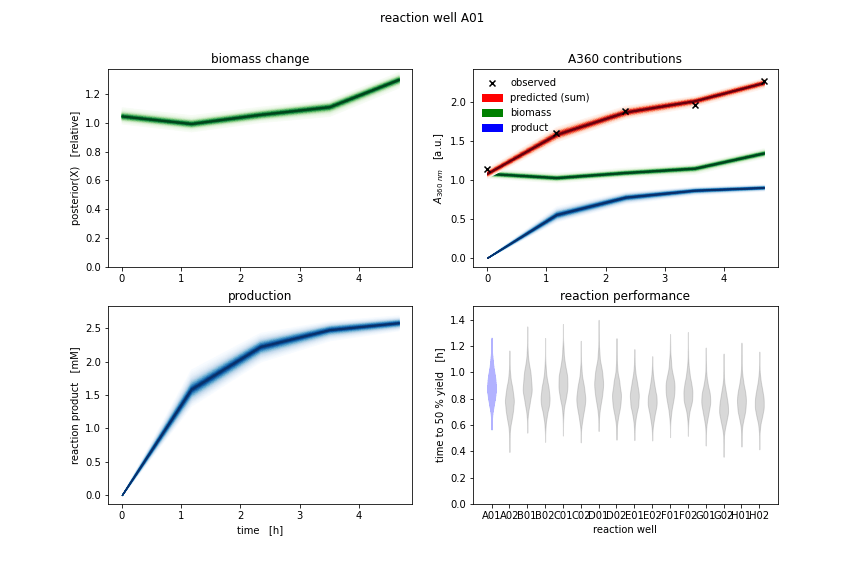

In [17]:
fp_out = plotting.plot_gif(
    fn_plot=lambda rwell: plotting.plot_reaction_well(idata, rwell),
    fp_out="reaction_results.gif",
    data=idata.posterior.reaction_well.values,
    fps=1.5
)
IPython.display.Image(fp_out)